In [1]:
import os
import pandas as pd
from dotenv import load_dotenv
from snowflake.snowpark import Session

In [2]:
load_dotenv()

True

In [3]:
ACCOUNT = os.getenv('ACCOUNT')
USER = os.getenv('SP_USER')
PASSWORD = os.getenv('PASSWORD')
ROLE = os.getenv('ROLE')
WAREHOUSE = os.getenv('WAREHOUSE')
DATABASE = os.getenv('DATABASE')
SCHEMA = os.getenv('SCHEMA')

print(ACCOUNT, USER, ROLE, WAREHOUSE, DATABASE, SCHEMA)

hum.us-east-2.aws ericatuva UVARND UVARND_WH CORE CLIENT


In [4]:
connection_parameters = {
    'account': os.getenv('ACCOUNT'),
    'user': USER,
    'password': os.getenv('PASSWORD'),
    'role': os.getenv('ROLE'),
    'warehouse': os.getenv('WAREHOUSE'),
    'database': os.getenv('DATABASE'),
    'schema': os.getenv('SCHEMA')
}

In [5]:
test_session = Session.builder.configs(connection_parameters).create()

In [6]:
events_query = """
SELECT 
    e.visitor_id
    , COUNT(DISTINCT e.id) AS events
    , COUNT(DISTINCT CASE WHEN e.event = 'cite' THEN e.id END) AS cite
    , COUNT(DISTINCT CASE WHEN e.event = 'pageview' THEN e.id END) AS page_view
    , COUNT(DISTINCT CASE WHEN e.event = 'pdf-click' THEN e.id END) AS pdf_click
    , COUNT(DISTINCT CASE WHEN e.event = 'post-read-start' THEN e.id END) AS post_read_start
    , COUNT(DISTINCT CASE WHEN e.event = 'post-read-mid' THEN e.id END) AS post_read_mid
    , COUNT(DISTINCT CASE WHEN e.event = 'post-read-end' THEN e.id END) AS post_read_end
FROM event e
WHERE DATE_TRUNC('year', e.day) = DATE('2022-01-01')
AND e.visitor_id IS NOT NULL
GROUP BY 1
ORDER BY 1
"""

In [7]:
print('querying...')
query_results = test_session.sql(events_query).collect()
print('query done')
test_session.close()
print('session closed')

querying...
query done
session closed


In [8]:
# convert to pandas df
query_json = list(map(lambda x: x.as_dict(), query_results))
query_df = pd.DataFrame(query_json)
query_df.to_csv('hist_data.csv', index = 0)
# query_df = pd.read_csv('events_data.csv')

In [2]:
query_df = pd.read_csv('hist_data.csv')

In [3]:
query_df

,VISITOR_ID,EVENTS,CITE,PAGE_VIEW,PDF_CLICK,POST_READ_START,POST_READ_MID,POST_READ_END
0,00000404-5bf6-4798-89d8-1592758d661e,3,0,3,0,0,0,0
1,000008b9-45d5-4ed2-8cfe-2463853d5640,4,0,1,0,1,1,1
2,00001624-b501-4b87-8cd6-a90760e47df8,4,0,1,0,1,1,1
3,00001e6f-ce60-4bf4-b356-4ab63181ccc3,4,0,1,0,1,1,1
4,00002124-5ca5-4a6f-9fd9-839062c866b3,8,0,2,0,2,2,2
...,...,...,...,...,...,...,...,...
1894585,ffffd7ea-c335-412e-a6f9-1676e2533cd5,12,0,3,0,3,3,3
1894586,ffffd8d1-e23e-49d4-9a1d-f24244edaeea,4,0,1,0,1,1,1
1894587,ffffe48e-5fde-4163-8e92-5d0d95bbc91a,1,0,1,0,0,0,0
1894588,ffffe76a-5434-4064-9cc3-274504915aeb,5,0,2,0,1,1,1


In [5]:
query_df.describe()

,EVENTS,CITE,PAGE_VIEW,PDF_CLICK,POST_READ_START,POST_READ_MID,POST_READ_END
count,1.894590e+06,1.894590e+06,1.894590e+06,1.894590e+06,1.894590e+06,1.894590e+06,1.894590e+06
mean,5.736532e+00,5.014277e-05,2.628142e+00,9.358225e-04,1.093936e+00,1.041909e+00,9.715585e-01
std,1.305868e+02,8.503451e-03,1.214370e+02,3.510893e-02,1.010269e+01,9.743132e+00,8.422191e+00
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,4.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
75%,4.000000e+00,0.000000e+00,2.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
max,6.795700e+04,6.000000e+00,6.641900e+04,9.000000e+00,4.689000e+03,4.564000e+03,4.053000e+03


In [3]:
hist_df = query_df[[
    'EVENTS', 
    'CITE', 
    'PAGE_VIEW', 
    'PDF_CLICK',
    'POST_READ_START',
    'POST_READ_MID',
    'POST_READ_END'
]]

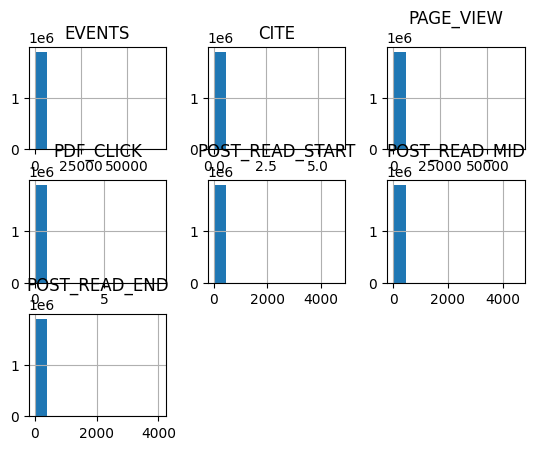

In [44]:
hist = hist_df.hist()

<AxesSubplot: >

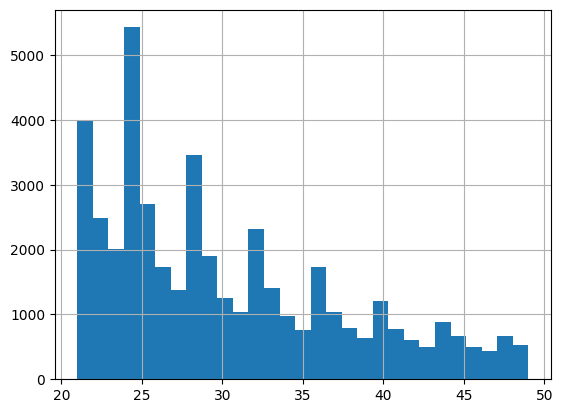

In [6]:
# remove outlier big events
hist_df['EVENTS'].where(lambda x: (x < 50) & (x > 20)).hist(bins = 29)

# spike every ~4 events, most users have ~4 events only
# figure out:
# 1. cyclicity
# 2. 20-50 events is good range to use - 12 different events, need at least 10x that
# each category should have >120 (more is better); 80-20 train-test split
# try 20-50 range vs 40-50 range at some point

<AxesSubplot: >

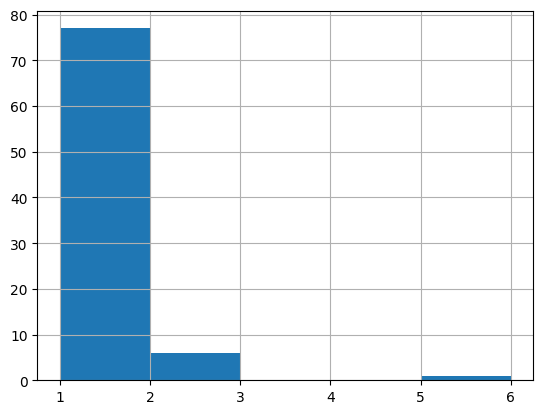

In [25]:
# majority has 0 citations
hist_df['CITE'].where(lambda x: x > 0).hist(bins = 5)

<AxesSubplot: >

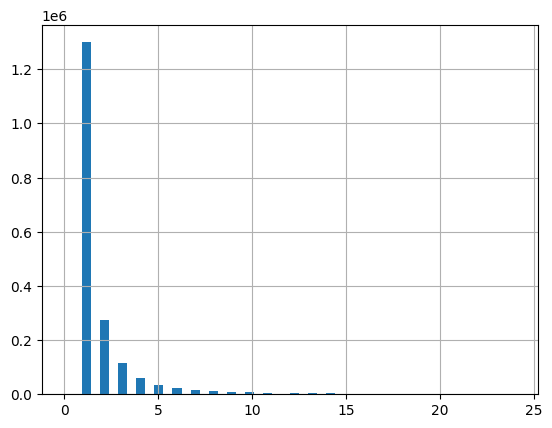

In [35]:
hist_df['PAGE_VIEW'].where(lambda x: x < 25).hist(bins = 50)

<AxesSubplot: >

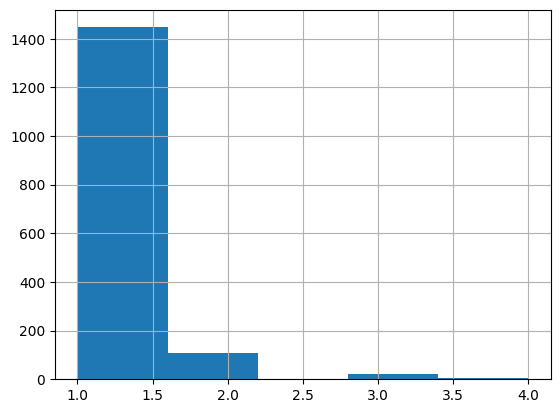

In [54]:
hist_df['PDF_CLICK'].where(lambda x: (x < 5) & (x > 0)).hist(bins = 5)

<AxesSubplot: >

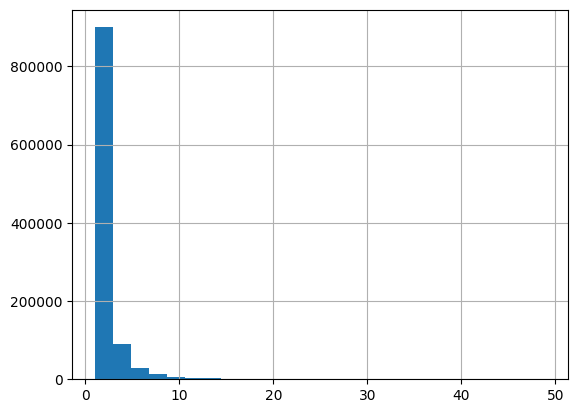

In [56]:
hist_df['POST_READ_START'].where(lambda x: (x < 50) & (x > 0)).hist(bins = 25)

<AxesSubplot: >

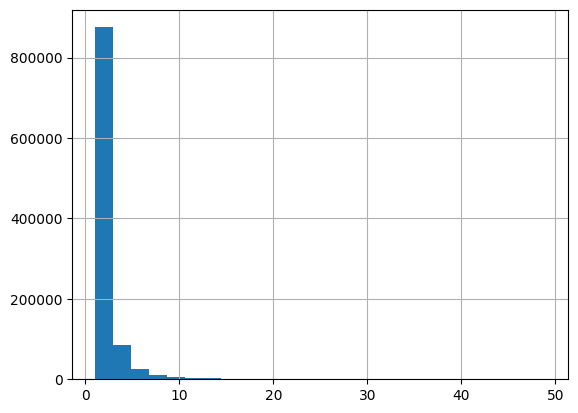

In [57]:
hist_df['POST_READ_MID'].where(lambda x: (x < 50) & (x > 0)).hist(bins = 25)

<AxesSubplot: >

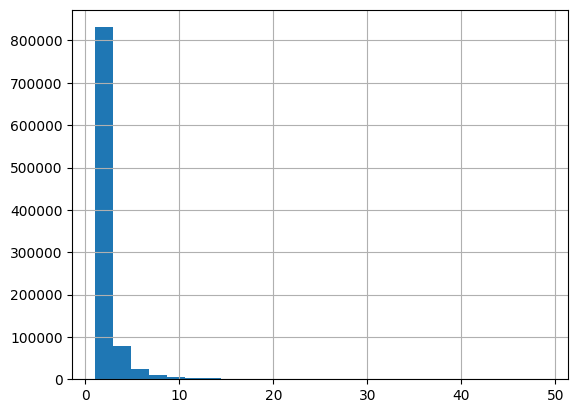

In [58]:
hist_df['POST_READ_END'].where(lambda x: (x < 50) & (x > 0)).hist(bins = 25)